In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 100 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from pyepo.model.grb import tspDFJModel, tspGGModel
# set solver
optmodel = tspDFJModel(num_node)
optmodel_gg = tspGGModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.7221
0 -> 10 -> 16 -> 5 -> 3 -> 17 -> 1 -> 4 -> 12 -> 14 -> 9 -> 11 -> 2 -> 7 -> 18 -> 13 -> 6 -> 19 -> 8 -> 15 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [5]:
from dataset import optDatasetConstrs
# get training and test data set
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train) # with binding constr
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test) # without binding constr

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 113.32it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.52it/s]


In [6]:
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols) # with binding constr

Obtaining constraints for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 101.29it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-10, num_epochs+10)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 50), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time
from earlystop import earlyStopper

def train(reg, loss_func, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    # init log
    loss_log = []
    regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
    regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
    # running time
    elapsed = 0
    for epoch in range(num_epochs):
        tick = time.time()
        for data in loader_train:
            x, w, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = loss_func(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
        # record time
        tock = time.time()
        elapsed += tock - tick
        if (epoch+1) % log_step == 1:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
            regret_log_val.append(regret_val)
            print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                  format(epoch, loss.item(), regret_trn*100, regret_val*100))
            # early stop
            if stopper.stop(regret_val):
                print("Early Stop!")
                break
    print("Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

### 2-Stage 

In [11]:
# init model
reg = LinearRegression()

In [12]:
from torch import nn
# init loss
mse = nn.MSELoss()

In [13]:
lr = 5e-2
num_epochs = 400
log_step = 20
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# set stopper
stopper = earlyStopper(patience=3)
# init log
loss_log = []
regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train_cost:
        x, c, _, _ = data
        # forward pass
        cp = reg(x)
        loss = mse(cp, c)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log_val.append(regret_val)
        print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
              format(epoch, loss.item(), regret_trn*100, regret_val*100))
        # early stop
        if stopper.stop(regret_val):
            print("Early Stop!")
            break
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  47.4542, Train Regret: 102.8860%, Val Regret: 117.6926%
Epoch  20, Loss:  13.0517, Train Regret:  21.9561%, Val Regret:  24.1884%
Epoch  40, Loss:   4.3930, Train Regret:  17.3520%, Val Regret:  19.5088%
Epoch  60, Loss:  12.5451, Train Regret:  15.8411%, Val Regret:  17.3756%
Epoch  80, Loss:   8.8629, Train Regret:  13.8236%, Val Regret:  15.8050%
Epoch 100, Loss:   5.0492, Train Regret:  13.9112%, Val Regret:  15.7455%
Epoch 120, Loss:   8.0730, Train Regret:  13.6914%, Val Regret:  15.4032%
Epoch 140, Loss:   4.6407, Train Regret:  13.8727%, Val Regret:  15.3838%
Epoch 160, Loss:   7.8581, Train Regret:  13.7796%, Val Regret:  15.2799%
Epoch 180, Loss:   9.1762, Train Regret:  13.6279%, Val Regret:  15.1517%
Epoch 200, Loss:   8.1834, Train Regret:  13.6639%, Val Regret:  15.5565%
Epoch 220, Loss:   9.2033, Train Regret:  14.2760%, Val Regret:  15.4346%
Epoch 240, Loss:   7.0610, Train Regret:  13.8362%, Val Regret:  15.5776%
Early Stop!
Elapsed Time: 1.57 Sec


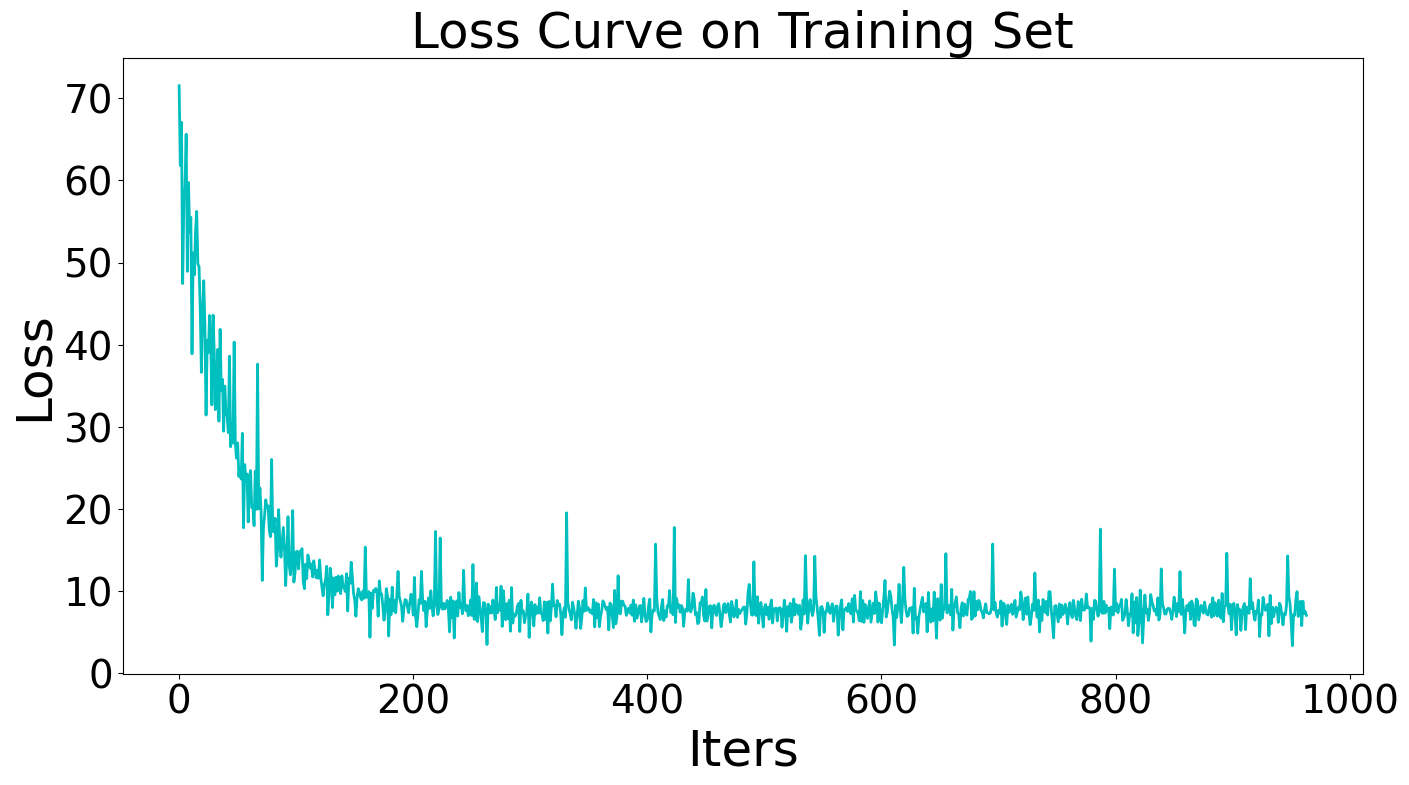

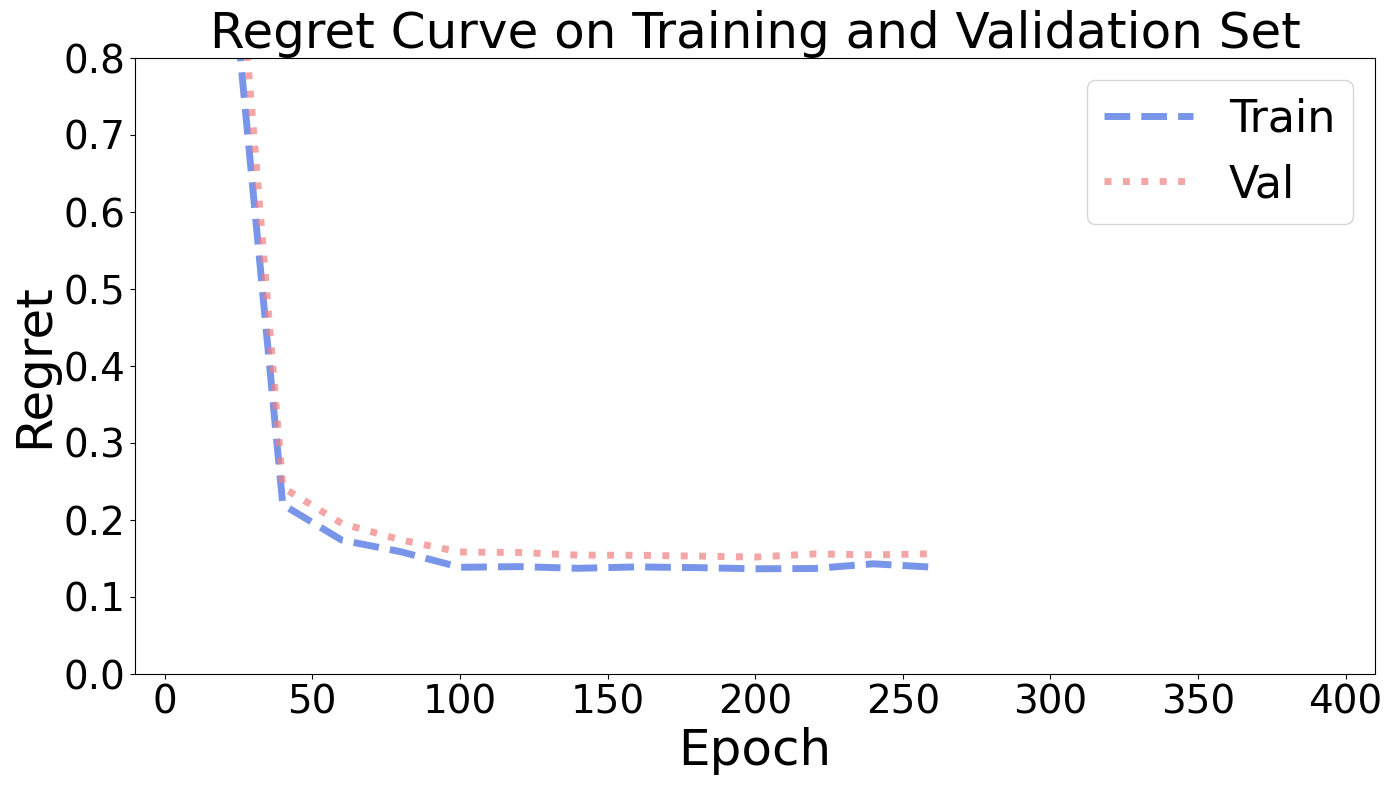

In [14]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method 

In [15]:
# init model
reg = LinearRegression()

In [16]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel)

In [17]:
lr = 5e-2
num_epochs = 400
log_step = 20
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9419, Train Regret: 102.2364%, Val Regret: 112.5526%
Epoch  20, Loss:  -0.9999, Train Regret:  10.1040%, Val Regret:  28.8482%
Epoch  40, Loss:  -1.0000, Train Regret:   7.0359%, Val Regret:  27.5887%
Epoch  60, Loss:  -1.0000, Train Regret:   4.0178%, Val Regret:  27.4923%
Epoch  80, Loss:  -1.0000, Train Regret:   2.8254%, Val Regret:  27.3684%
Epoch 100, Loss:  -1.0000, Train Regret:   0.9353%, Val Regret:  27.4063%
Epoch 120, Loss:  -1.0000, Train Regret:  -0.0000%, Val Regret:  27.3803%
Epoch 140, Loss:  -1.0000, Train Regret:  -0.0000%, Val Regret:  27.3521%
Epoch 160, Loss:  -1.0000, Train Regret:  -0.0000%, Val Regret:  27.3323%
Epoch 180, Loss:  -1.0000, Train Regret:  -0.0000%, Val Regret:  27.3418%
Epoch 200, Loss:  -1.0000, Train Regret:  -0.0000%, Val Regret:  27.3421%
Epoch 220, Loss:  -1.0000, Train Regret:  -0.0000%, Val Regret:  27.3510%
Epoch 240, Loss:  -1.0000, Train Regret:  -0.0000%, Val Regret:  27.3510%
Epoch 260, Loss:  -1.0000, Train Regre

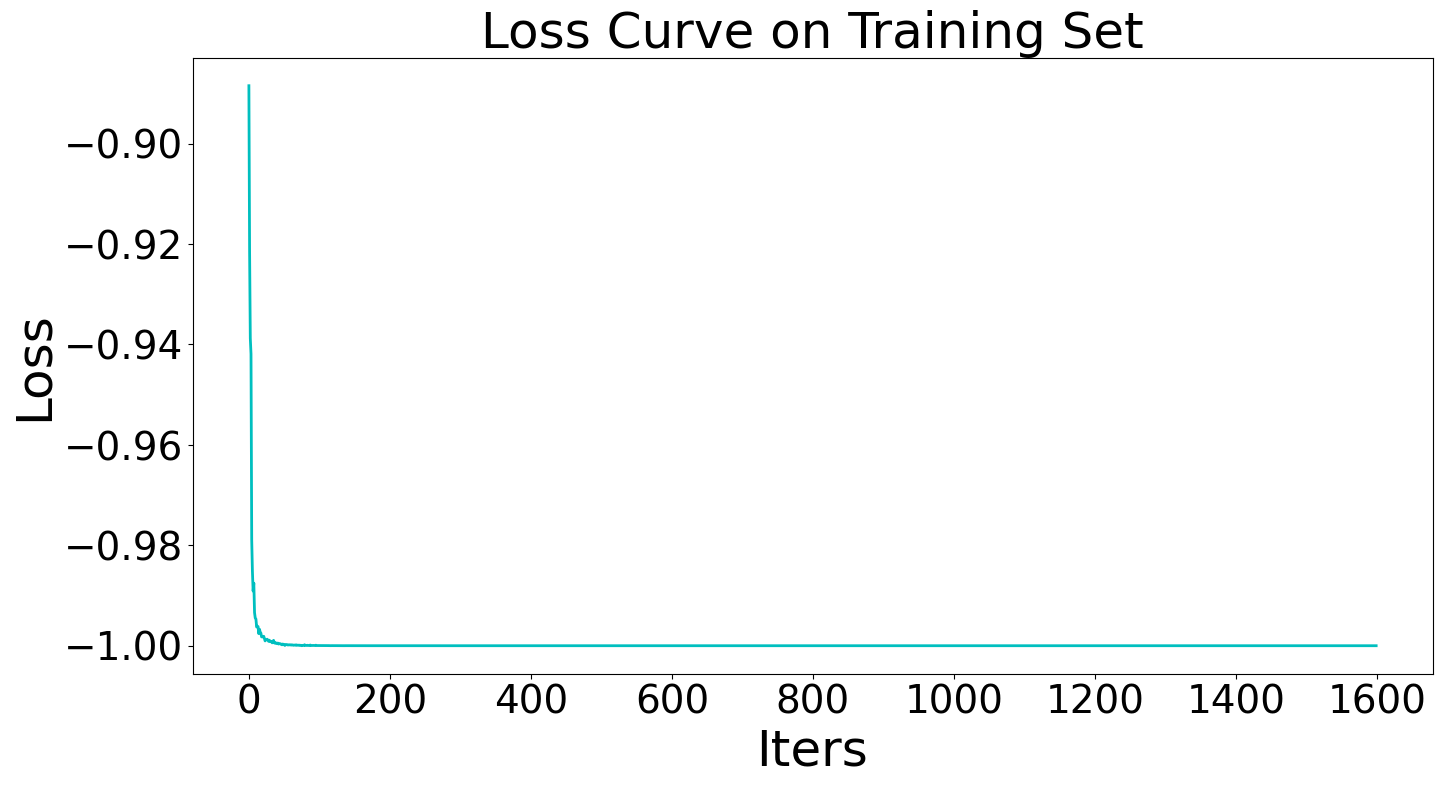

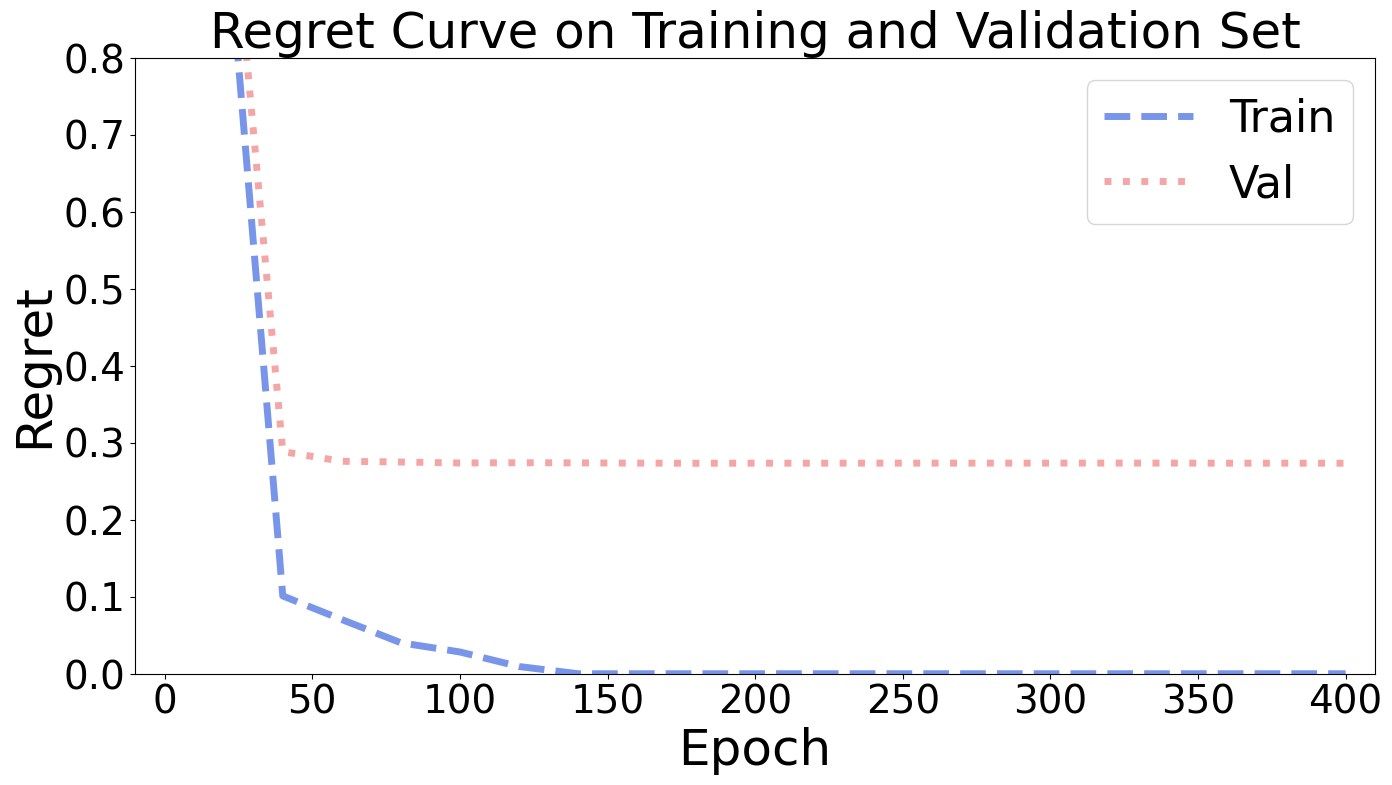

In [18]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [19]:
# init model
reg = LinearRegression()

In [20]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [21]:
lr = 5e-2
num_epochs = 400
log_step = 20
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.2819, Train Regret: 147.4392%, Val Regret: 157.1381%
Epoch  20, Loss:  -0.8045, Train Regret:  14.4942%, Val Regret:  24.6168%
Epoch  40, Loss:  -0.8222, Train Regret:  15.2784%, Val Regret:  24.2475%
Epoch  60, Loss:  -0.8216, Train Regret:  15.1551%, Val Regret:  23.5987%
Epoch  80, Loss:  -0.8223, Train Regret:  12.6172%, Val Regret:  23.7181%
Epoch 100, Loss:  -0.8261, Train Regret:  15.3177%, Val Regret:  23.9413%
Epoch 120, Loss:  -0.8237, Train Regret:  13.0891%, Val Regret:  23.3580%
Epoch 140, Loss:  -0.7966, Train Regret:  14.0518%, Val Regret:  22.2645%
Epoch 160, Loss:  -0.8475, Train Regret:  13.7605%, Val Regret:  23.6337%
Epoch 180, Loss:  -0.8052, Train Regret:  12.7989%, Val Regret:  22.0406%
Epoch 200, Loss:  -0.8252, Train Regret:  13.5372%, Val Regret:  23.7680%
Epoch 220, Loss:  -0.8348, Train Regret:  11.6677%, Val Regret:  22.3762%
Epoch 240, Loss:  -0.8151, Train Regret:  13.3385%, Val Regret:  22.4395%
Early Stop!
Elapsed Time: 18.72 Sec


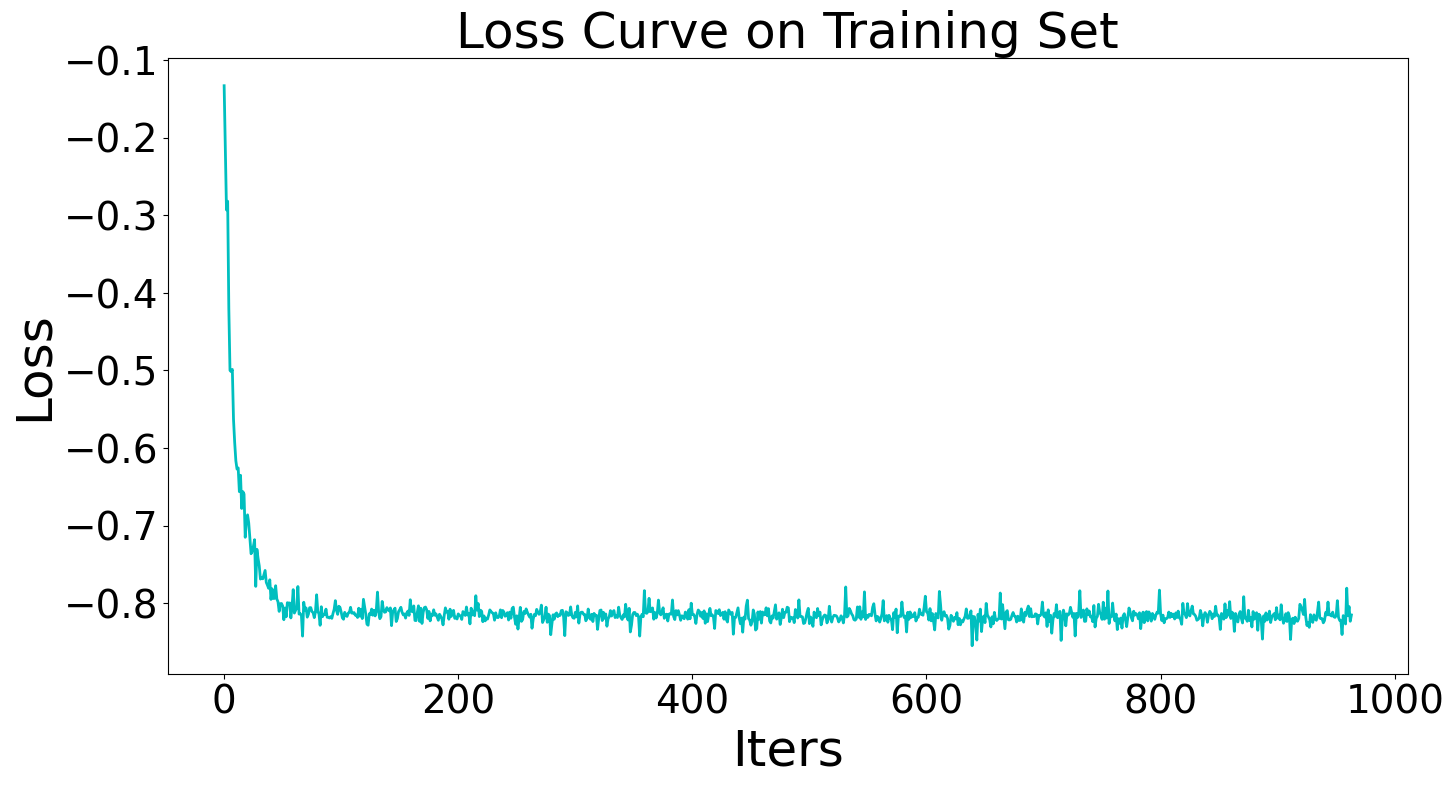

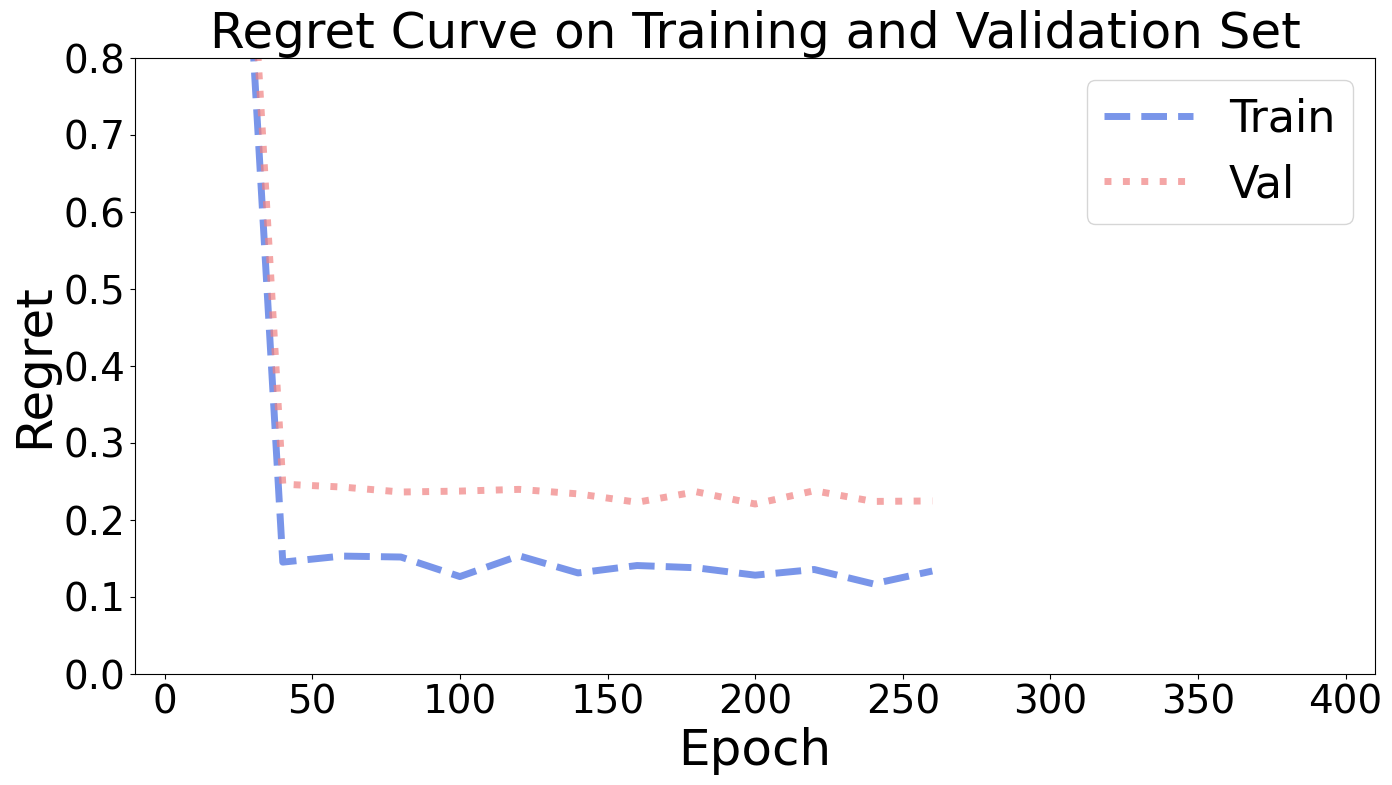

In [22]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sign Method

In [23]:
# init model
reg = LinearRegression()

In [24]:
from func import signConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel)

In [25]:
lr = 5e-2
num_epochs = 40
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.8860, Train Regret: 104.0522%, Val Regret: 132.4152%
Epoch   2, Loss:  -0.9565, Train Regret:  49.6028%, Val Regret:  74.2826%
Epoch   4, Loss:  -0.9873, Train Regret:  35.3541%, Val Regret:  56.4301%
Epoch   6, Loss:  -0.9936, Train Regret:  30.9591%, Val Regret:  47.4999%
Epoch   8, Loss:  -0.9970, Train Regret:  23.5883%, Val Regret:  41.8258%
Epoch  10, Loss:  -0.9968, Train Regret:  22.0564%, Val Regret:  37.5250%
Epoch  12, Loss:  -0.9987, Train Regret:  18.9056%, Val Regret:  34.7724%
Epoch  14, Loss:  -0.9980, Train Regret:  17.6490%, Val Regret:  32.9331%
Epoch  16, Loss:  -0.9979, Train Regret:  14.1829%, Val Regret:  32.2689%
Epoch  18, Loss:  -0.9986, Train Regret:  12.2996%, Val Regret:  31.4877%
Epoch  20, Loss:  -0.9993, Train Regret:  11.2194%, Val Regret:  31.0875%
Epoch  22, Loss:  -0.9983, Train Regret:  11.0663%, Val Regret:  30.7760%
Epoch  24, Loss:  -0.9991, Train Regret:  11.4715%, Val Regret:  30.8788%
Epoch  26, Loss:  -0.9991, Train Regre

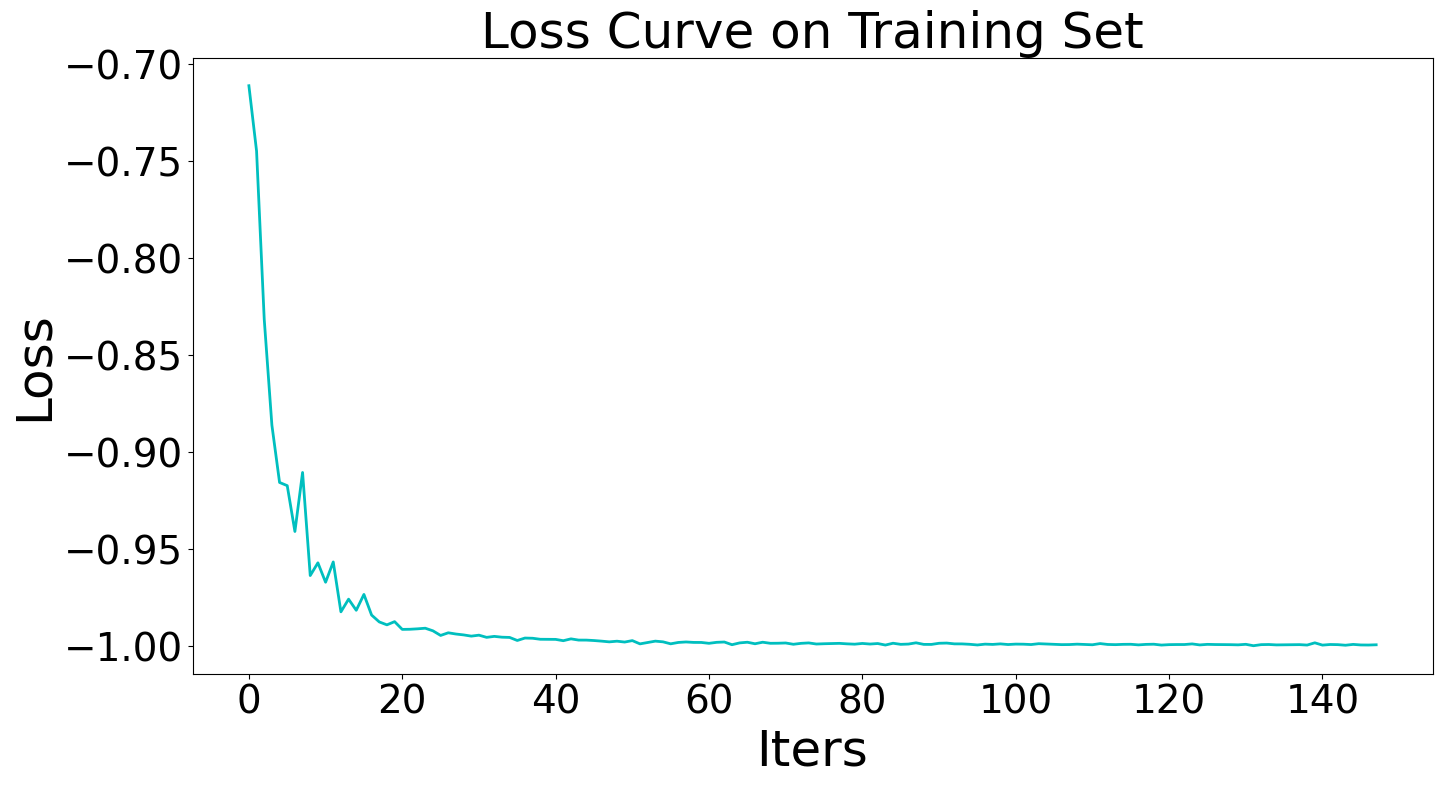

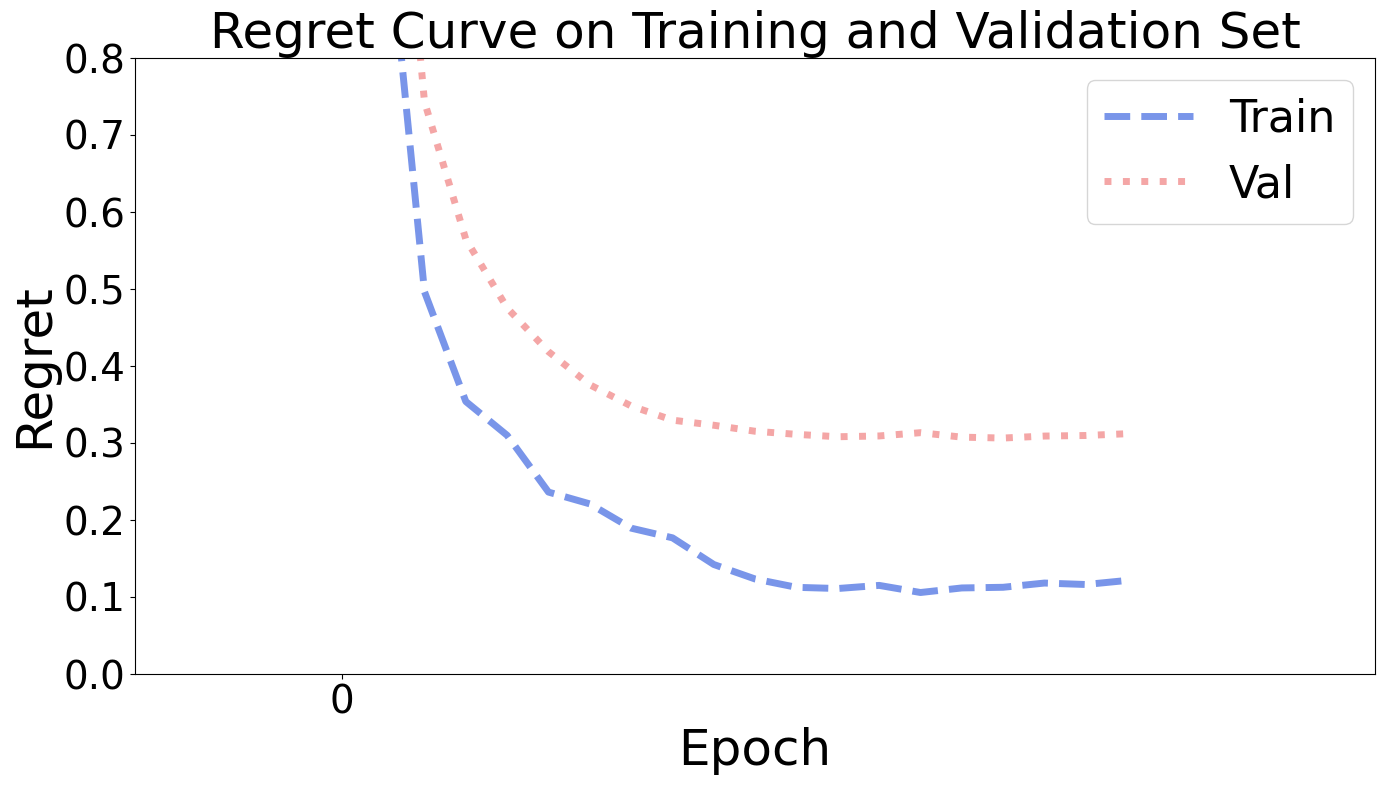

In [26]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [27]:
# init model
reg = LinearRegression()

In [28]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=3, sigma=1.0)

Num of cores: 1


In [29]:
lr = 1e-2
num_epochs = 400
log_step = 20
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# set stopper
stopper = earlyStopper(patience=3)
# init log
loss_log = []
regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train:
        x, w, t_ctr = data
        # forward pass
        cp = reg(x)
        loss = pfy(cp, w)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log_val.append(regret_val)
        print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, loss.item(), regret_trn*100, regret_val*100))
        # early stop
        if stopper.stop(regret_val):
            print("Early Stop!")
            break
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  25.2222, Train Regret: 174.1691%, Val Regret: 183.3422%
Epoch  20, Loss:  11.9444, Train Regret:  12.5309%, Val Regret:  23.4306%
Epoch  40, Loss:  11.6111, Train Regret:   5.8874%, Val Regret:  18.1212%
Epoch  60, Loss:   7.5000, Train Regret:   4.6045%, Val Regret:  16.6122%
Epoch  80, Loss:   8.4444, Train Regret:   3.6065%, Val Regret:  16.2856%
Epoch 100, Loss:   7.5000, Train Regret:   2.9750%, Val Regret:  16.1365%
Epoch 120, Loss:   6.0556, Train Regret:   2.6218%, Val Regret:  15.9268%
Epoch 140, Loss:   6.1111, Train Regret:   2.7304%, Val Regret:  16.0634%
Epoch 160, Loss:   6.6111, Train Regret:   2.1757%, Val Regret:  15.9820%
Epoch 180, Loss:   5.6111, Train Regret:   2.0515%, Val Regret:  15.5806%
Epoch 200, Loss:   3.3333, Train Regret:   1.8055%, Val Regret:  15.8109%
Epoch 220, Loss:   5.1667, Train Regret:   1.4260%, Val Regret:  15.9675%
Epoch 240, Loss:   8.0556, Train Regret:   1.4451%, Val Regret:  16.0930%
Early Stop!
Elapsed Time: 752.46 Sec


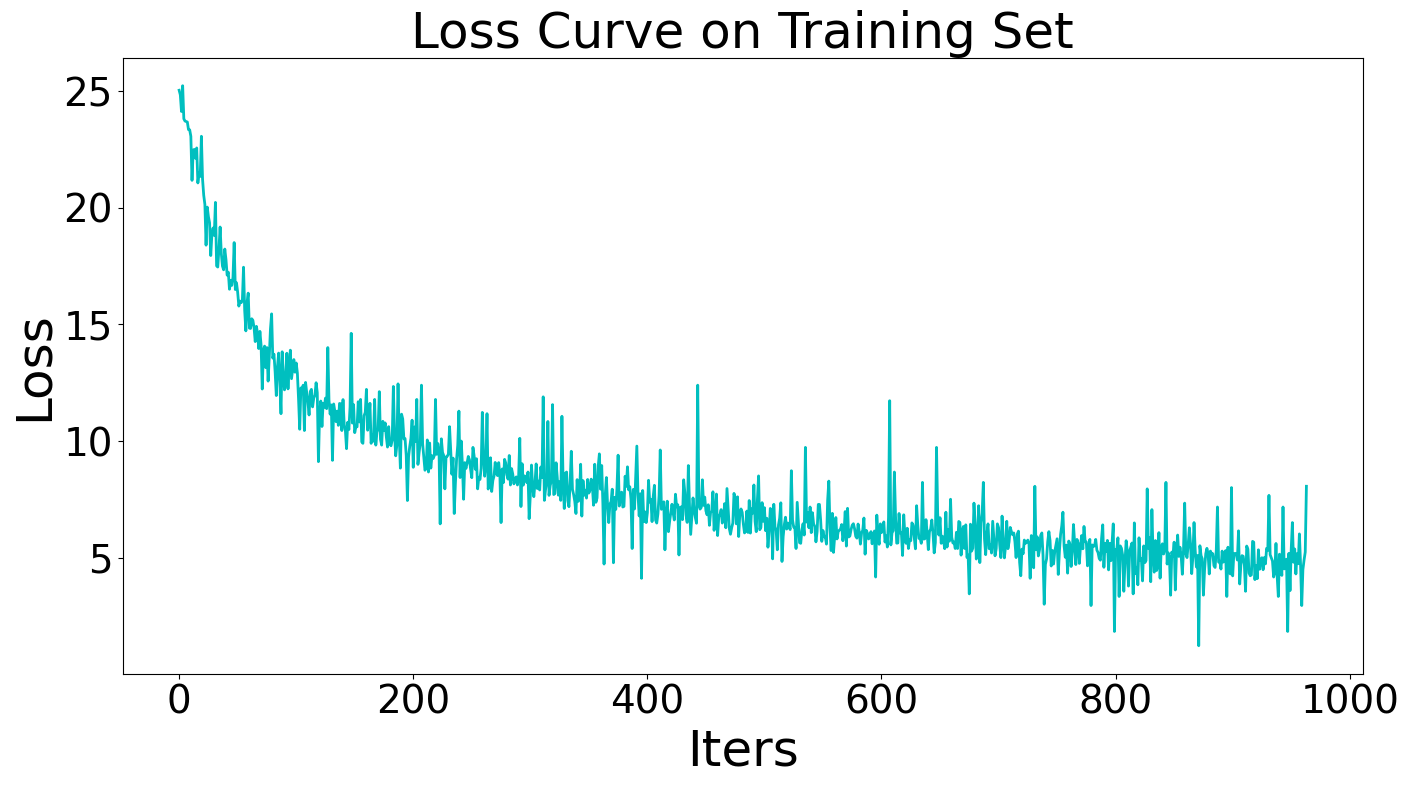

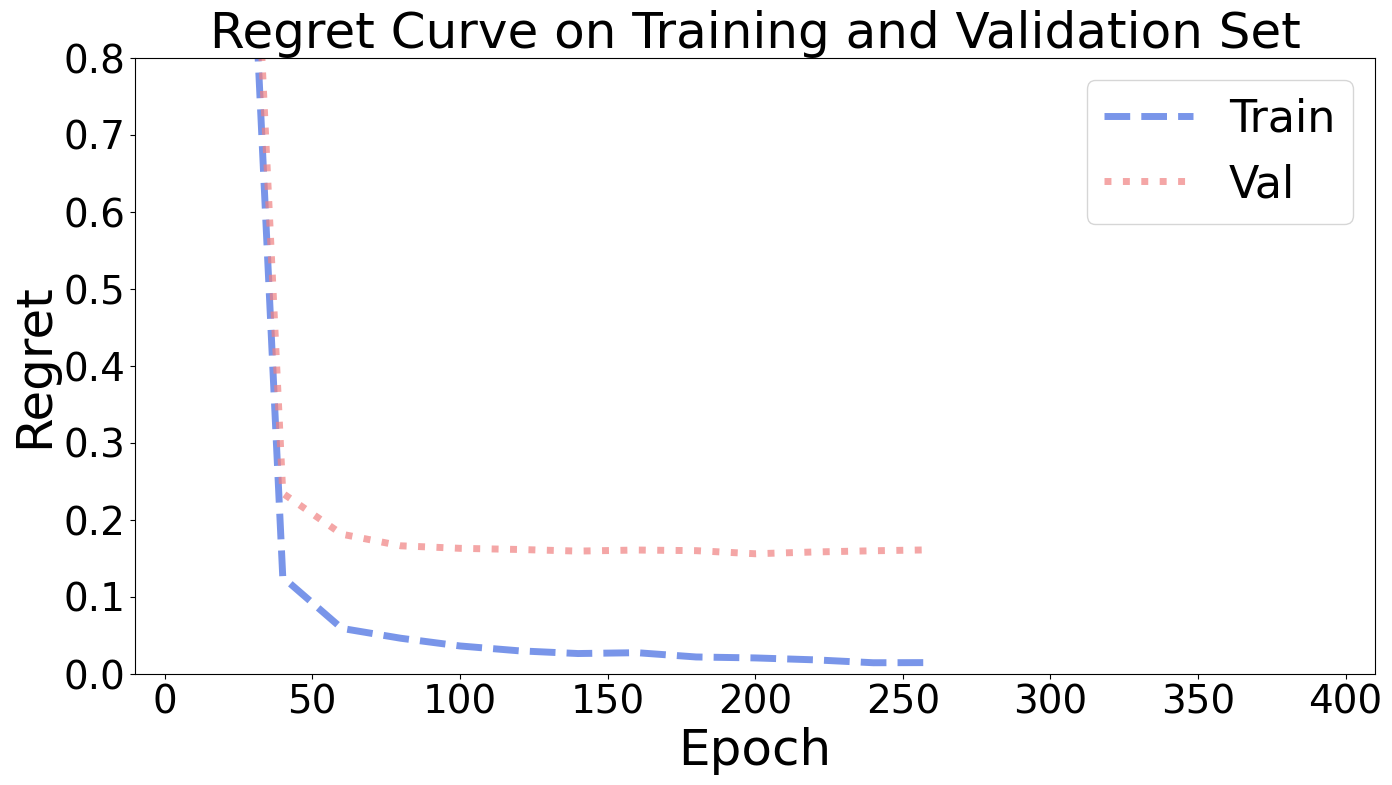

In [30]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)